In [ ]:
import sys
from glob import glob
from os import path as osp
from datetime import datetime
from tqdm import tqdm
from skimage import io, transform
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
# torch imports
import torch
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader

# root path of project
from os import path as osp
import sys

# get root directory
import re
reg = '^.*/AquaPose'
project_root = re.findall(reg, osp.dirname(osp.abspath(sys.argv[0])))[0]
sys.path.append(project_root)

from lib.dataset.PoseDataset import PoseDataset

from lib.models.keypoint_rcnn import get_resnet50_pretrained_model

# utils
from lib.utils.slack_notifications import slack_message
from lib.utils.select_gpu import select_best_gpu

# references import
# source: https://github.com/pytorch/vision/tree/master/references/detection
from references.engine import train_one_epoch, evaluate
from references.utils import collate_fn


In [22]:
def tensor_to_numpy_image(img_tensor):
    return img_tensor.permute(1,2,0).detach().numpy()

def get_max_prediction(prediction):
    keypoints_scores = prediction[0]['keypoints_scores']
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    keypoints = prediction[0]['keypoints']

    max_score = 0
    max_box = []
    for idx, box in enumerate(boxes):
        if scores[idx].item() > max_score:
            print(labels[idx].data.numpy())
            max_score = scores[idx].item()
            max_box = box
            max_keypoints = keypoints[idx] 
            max_keypoints_scores = keypoints_scores[idx]
    
    return max_box.detach().numpy(), max_keypoints.detach().numpy(), max_keypoints_scores.detach().numpy()

## Load dataset

In [ ]:
# load dataset to get a set of poses to match to
ref_dataset = PoseDataset([osp.join(project_root,'data/vzf/freestyle/freestyle_2'), osp.join(project_root,'data/vzf/freestyle/freestyle_3')], train=False)

## Get model and select weights

In [ ]:
weight_dir = osp.join(project_root, 'weights')
weight_files = glob(osp.join(weight_dir,'*'))
model = get_resnet50_pretrained_model()
#print(weight_files)
model.load_state_dict(torch.load(weight_files[-1], map_location=torch.device('cpu')))


## Show prediction + Groundtruth

1


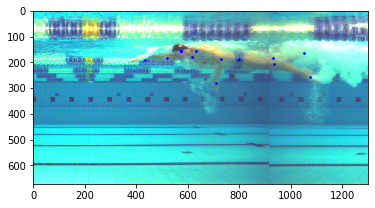

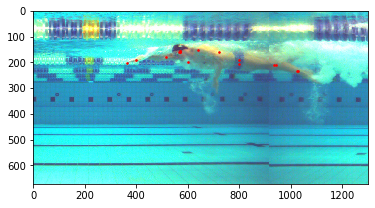

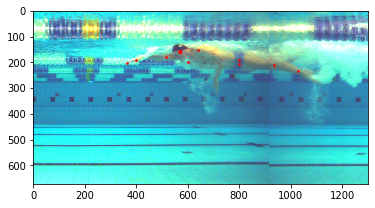

In [39]:
# load test dataset 
test_dataset = PoseDataset([osp.join(project_root,'data/vzf/freestyle/freestyle_1')], train=False)

# get prediction
test_id = 50
test_img, test_target = test_dataset[test_id]
model.eval()
prediction = model([test_img])

# get poses pred and GT
test_pred_box, test_pred_kp, test_pred_scores = get_max_prediction(prediction)
test_gt_kp = test_target['keypoints'][0]
# set all visible
test_gt_kp_all_vis = [[kp[0], kp[1], 1] for kp in test_gt_kp]

# plot groundtruth
fig, ax = plt.subplots()
plt.imshow(tensor_to_numpy_image(test_img))
ax.scatter(np.array(test_gt_kp)[:,0],np.array(test_gt_kp)[:,1], s=10, marker='.', c='b')

# plot prediction
fig, ax = plt.subplots()
plt.imshow(tensor_to_numpy_image(test_img))
ax.scatter(np.array(test_pred_kp)[:,0],np.array(test_pred_kp)[:,1], s=10, marker='.', c='r')

# plot positive prediction
fig, ax = plt.subplots()
plt.imshow(tensor_to_numpy_image(test_img))
#print(test_pred_scores)
filter_inds = np.argwhere(test_pred_scores > 0).flatten()
test_pred_kp_ftrd = test_pred_kp[filter_inds]
ax.scatter(np.array(test_pred_kp_ftrd)[:,0],np.array(test_pred_kp_ftrd)[:,1], s=10, marker='.', c='r')


In [49]:
# occluded=True will only use occluded gt points
# side = right/left will only use those keypoints
def filter_kps(pred_kps, ref_kps, scores, min_score=0, occluded=True, side = None):
    # merge all head keypoints into 'head'
    pred_kps = pred_kps[4:]
    ref_kps = ref_kps[4:]
    scores = scores[4:]

    filter_ind = np.argwhere(scores > min_score).flatten()

    if not occluded:
        not_occluded = np.argwhere(ref_kps[:,2] > 0).flatten()
        filter_ind = np.intersect1d(filter_ind, not_occluded)

    if side == 'left':
        left_ind = [0, 1 ,3 ,5 ,7 ,9, 11, 13, 15]
        filter_ind = np.intersect1d(filter_ind, left_ind)
    elif side == 'right':
        right_ind = [0, 2, 4, 6, 8, 10, 12, 14, 16]
        filter_ind = np.intersect1d(filter_ind, left_ind)

    pred_kps_ftrd = pred_kps[filter_ind]
    ref_kps_ftrd = ref_kps[filter_ind]
    scores_ftrd = scores[filter_ind]

    return pred_kps_ftrd, ref_kps_ftrd, scores_ftrd

def get_affine_tf(pred_kps, ref_kps):
    # make sure the visibility flag is 1 always (necessary for tf)
    ref_kps_vis = [[kp[0], kp[1], 1] for kp in ref_kps]

    A, res, rank, s = np.linalg.lstsq(pred_kps, ref_kps_vis)
    return A

def warp_kp(kps, tf_mat):
    


## Test by warping the prediction to its own ground truth

In [ ]:
# filter
test_pred_kp_ftrd, test_gt_kp_ftrd, test_pred_scores_ftrd = filter_kps(test_pred_kp, test_gt_kp, test_pred_scores, min_score=0, occluded=True)

tf_matrix = get_affine_tf(test_pred_kp_ftrd, test_gt_kp_ftrd)

